In [1]:
#import necessary libraries
import torch 
import torchvision
import matplotlib.pyplot as plt

from torchvision import transforms
from torch.utils.data import DataLoader

%matplotlib inline

#hyperparameters
batch_size = 1
num_epochs = 10
learning_rate = 0.01

#paths
checkpoint_path = 'model_checkpoints/model_checkpoint.pth'

In [2]:
#downloading data via kaggle api
from utils.data_utils import download_lung_semantic_data 
download_lung_semantic_data()

100%|█████████▉| 2.59G/2.59G [02:48<00:00, 17.2MB/s] 


Error: Target directory 'data' not empty. Have you already downloaded the data?


100%|██████████| 2.59G/2.59G [02:49<00:00, 16.4MB/s]


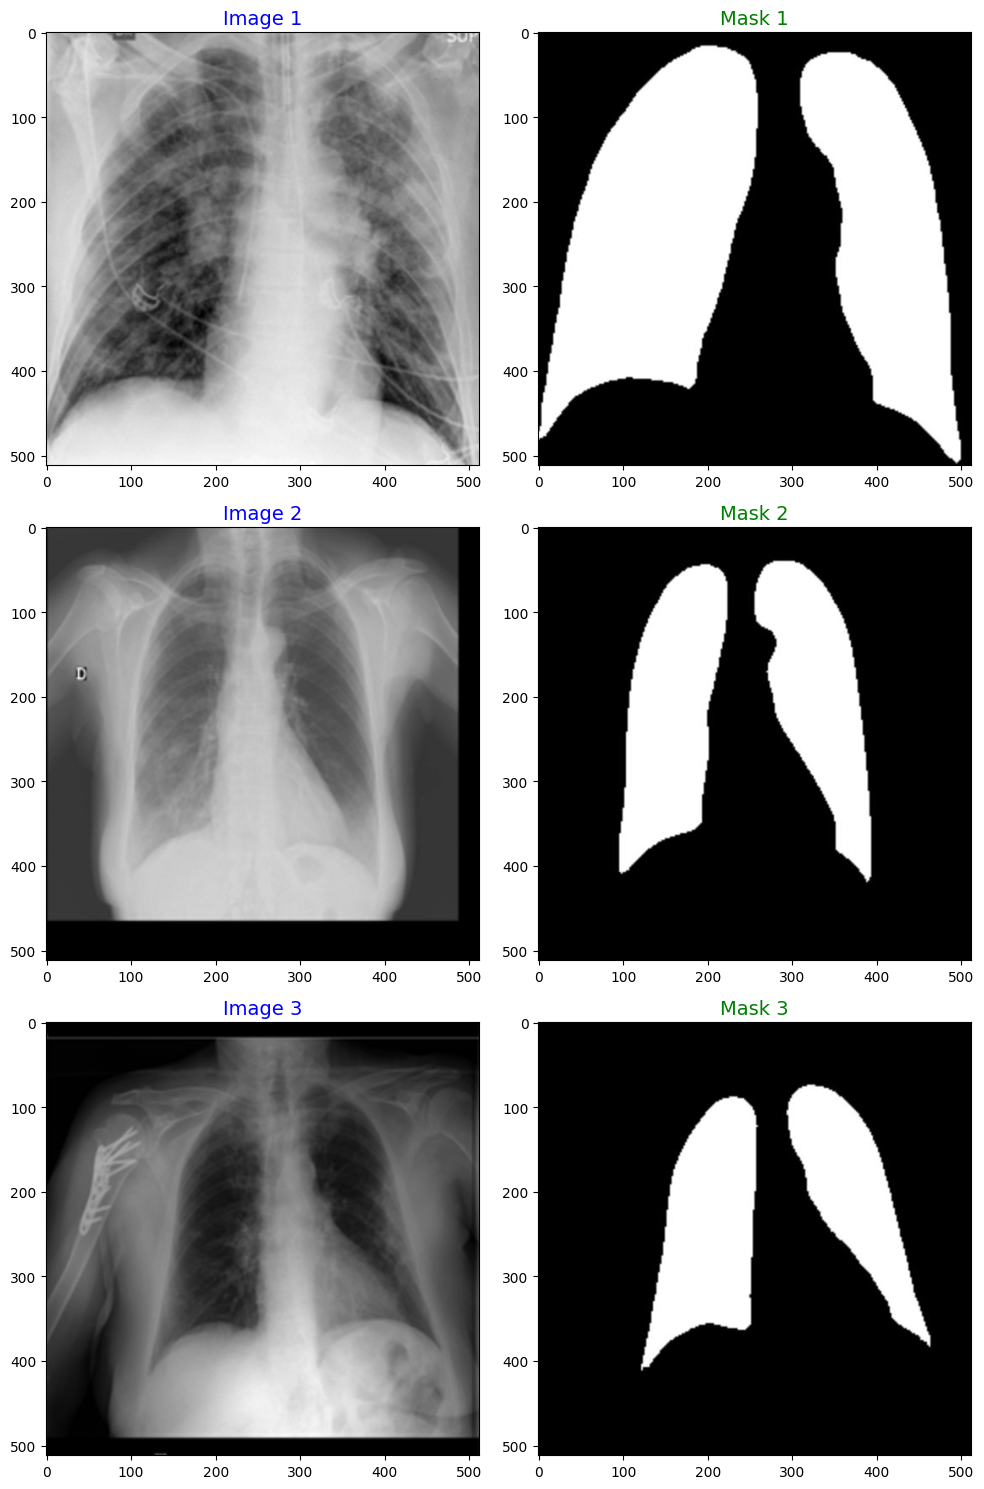

In [3]:
#displaying some random images and masks
from utils.data_utils import display_image_and_mask
display_image_and_mask(num_images=3)


In [4]:
#using custom dataset class to load data
from utils.pytorch_utils import LungDataset

composed = torchvision.transforms.Compose([
	transforms.Resize((512, 512)),
	transforms.ToTensor(),
])

train_size = 100	
val_size = 10
test_size = None

train_dataset = LungDataset(path='data/train', transform=composed, num=train_size)
val_dataset = LungDataset(path='data/val', transform=composed, num=val_size)
test_dataset = LungDataset(path='data/test', transform=composed, num=test_size)

train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)

print(f'#training examples: {len(train_dataset)}\n#test examples: {len(test_dataset)}\n#validation examples: {len(val_dataset)}')

#training examples: 100
#test examples: 2116
#validation examples: 10


In [5]:
#creating dataloaders for training, testing and validation

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [6]:
from models.UNet import UNet

model = UNet(1, 1)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.99)

debug = True
train_losses = []
val_losses = []

start_epoch = 1

In [7]:
from utils.helper import checkpoint, resume, print_progress

if start_epoch > 0:	
	resume_epoch = start_epoch - 1
	resume(model, f'model_states/epoch-{resume_epoch}.pth')

for epoch in range(start_epoch, num_epochs):
	train_loss = 0
	model.train()
	batch_number = 0

	for X_batch, y_batch in train_dataloader:
		y_pred = model(X_batch)

		loss = criterion(y_pred, y_batch)	
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		train_loss = loss.item()
		
		batch_number += 1
		print_progress(epoch+1, batch_number, len(train_dataloader))
		
	avg_train_loss = train_loss / train_size
	train_losses.append(avg_train_loss)

	model.eval()
	val_loss = 0
	with torch.no_grad():
		for X_batch, y_batch in val_dataloader:
			y_pred = model(X_batch)
			val_loss += criterion(y_pred, y_batch).item()
	
	avg_val_loss = val_loss / val_size
	val_losses.append(avg_val_loss)
	
	plt.figure(figsize=(10, 5))
	plt.plot(train_losses, label='Train Loss')
	plt.plot(val_losses, label='Validation Loss')
	plt.title(f'Epoch {epoch + 1}/{num_epochs}')
	plt.xlabel('Epoch')

	plt.ylabel('Loss')
	plt.legend()
	plt.show()

	checkpoint(model, f'model_states/epoch-{epoch}.pth')
	plt.savefig(f'plots/epoch-{epoch}.jpg', format='jpg')
	
	
	print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')



KeyboardInterrupt: 